In [59]:
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.utils.data
import cv2
import torch
import torchvision
import os
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import random
from time import perf_counter

In [60]:
print(torchvision.__version__)
print(torch.__version__)

0.14.0
1.13.0


In [61]:
class config:
    CONFIG_SET = 3
    ROOT_DIR  = "./resize_128/test"
    IMAGE_DIR = "./resize_128/test/image"
    MASK_DIR = "./resize_128/test/mask"
    ANNOTATION_DIR =  "./resize_128/test/json"
    MODEL_DIR = "./resize_128/result/model/"
        
    WIDTH = 128
    HEIGHT = 128


    GPU = torch.device("cuda")
    CPU = torch.device("cpu")

    RESNET_MEAN = (0.485, 0.456, 0.406)
    RESNET_STD = (0.229, 0.224, 0.225)

    IMAGE_RESIZE=(128,128)

    BATCH_SIZE = 2

    MOMENTUM = 0.9
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0005


    MASK_THRESHOLD = 0.5

    NORMALIZE = False 


    USE_SCHEDULER = False

    NUM_EPOCHS = 4


    BOX_DETECTIONS_PER_IMG = 539

    NUM_CLASSES=2
    
    MIN_SCORE = 0.70

In [62]:
config_set = [
        {
            "ROOT_DIR"  : "./resize_128/test",
            "IMAGE_DIR" : "./resize_128/test/image",
            "MASK_DIR" : "./resize_128/test/mask",
            "ANNOTATION_DIR" :  "./resize_128/test/json",
            "MODEL_DIR" : "./resize_128/result/model/",
            "WIDTH" : 128,
            "HEIGHT" : 128,
            "IMAGE_RESIZE":(128,128),
        },
        {
            "ROOT_DIR"  : "./crop_128/test",
            "IMAGE_DIR" : "./crop_128/test/image",
            "MASK_DIR" : "./crop_128/test/mask",
            "ANNOTATION_DIR" :  "./crop_128/test/json",
            "MODEL_DIR" : "./crop_128/result/model/",
            "WIDTH" : 128,
            "HEIGHT" : 128,
            "IMAGE_RESIZE":(128,128),
        },
        {
            "ROOT_DIR"  : "./resize_512/test",
            "IMAGE_DIR" : "./resize_512/test/image",
            "MASK_DIR" : "./resize_512/test/mask",
            "ANNOTATION_DIR" :  "./resize_512/test/json",
            "MODEL_DIR" : "./resize_512/result/model/",
            "WIDTH" : 512,
            "HEIGHT" : 512,
            "IMAGE_RESIZE":(512,512),
        },
        {
            "ROOT_DIR"  : "./crop_512/test",
            "IMAGE_DIR" : "./crop_512/test/image",
            "MASK_DIR" : "./crop_512/test/mask",
            "ANNOTATION_DIR" :  "./crop_512/test/json",
            "MODEL_DIR" : "./crop_512/result/model/",
            "WIDTH" : 512,
            "HEIGHT" : 512,
            "IMAGE_RESIZE":(512,512),
        }
    ]

config.ROOT_DIR  = config_set[config.CONFIG_SET]["ROOT_DIR"]
config.IMAGE_DIR = config_set[config.CONFIG_SET]["IMAGE_DIR"]
config.MASK_DIR = config_set[config.CONFIG_SET]["MASK_DIR"]
config.ANNOTATION_DIR =config_set[config.CONFIG_SET]["ANNOTATION_DIR"]
config.MODEL_DIR = config_set[config.CONFIG_SET]["MODEL_DIR"]
config.WIDTH = config_set[config.CONFIG_SET]["WIDTH"]
config.HEIGHT = config_set[config.CONFIG_SET]["HEIGHT"]
config.IMAGE_RESIZE=config_set[config.CONFIG_SET]["IMAGE_RESIZE"]


In [63]:
data_test = []
for  image,annot,mask in zip(os.listdir(config.IMAGE_DIR), os.listdir(config.ANNOTATION_DIR), os.listdir(config.MASK_DIR)):
    with open(os.path.join(config.ANNOTATION_DIR,annot), "r") as file:
        dictionary = json.load(file)
        dictionary["file"] = os.path.join(config.IMAGE_DIR, image)
        dictionary["mask"] = os.path.join(config.MASK_DIR, mask)
        data_test.append(dictionary)

data_test = pd.DataFrame(data_test)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        265 non-null    object
 1   n_object    265 non-null    int64 
 2   annotation  265 non-null    object
 3   box         265 non-null    object
 4   mask        265 non-null    object
dtypes: int64(1), object(4)
memory usage: 10.5+ KB


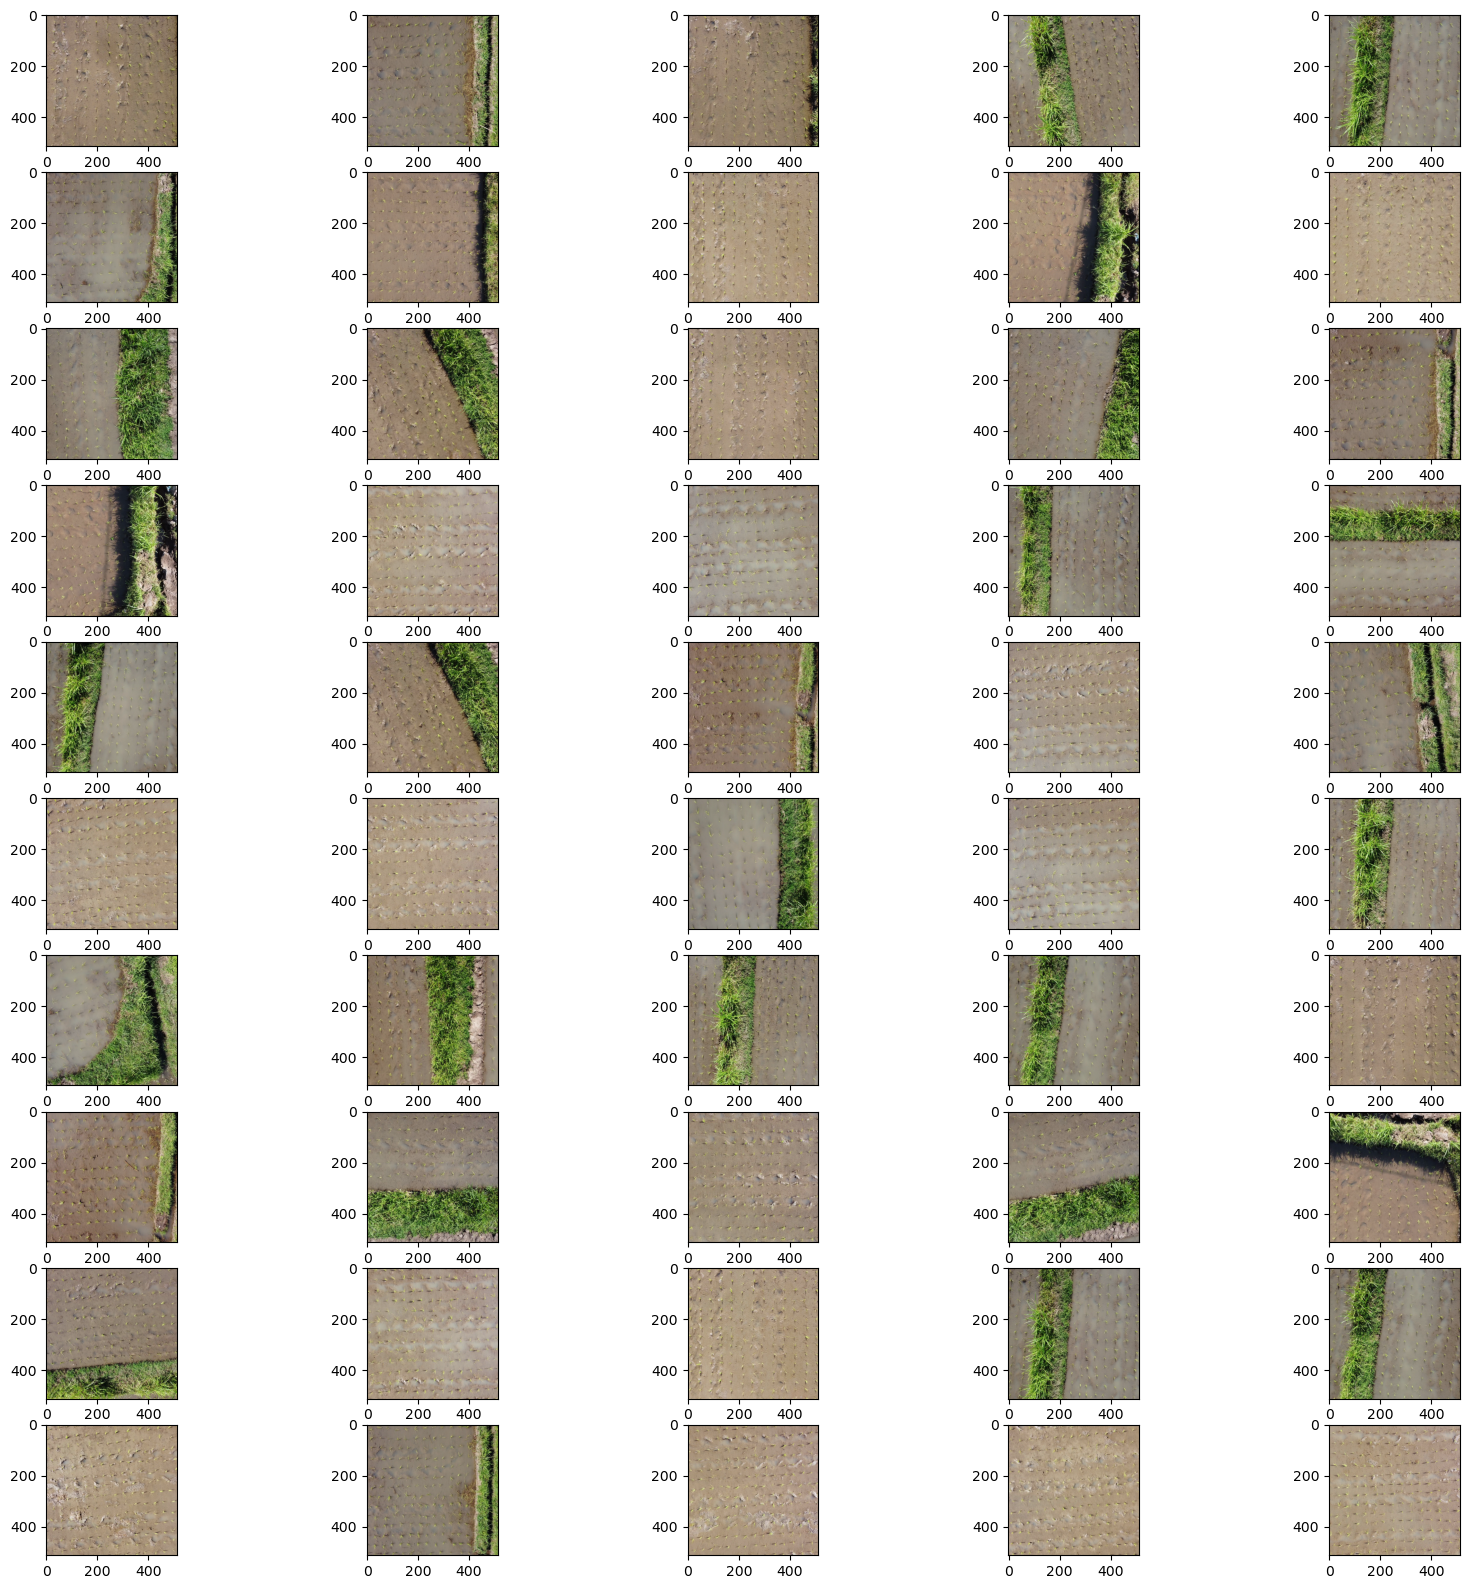

In [64]:
data_length = len(data_test)
w,h = 20,20

fig=plt.figure(figsize=(20, 20))
cols , rows = 5, 10

for i in range(cols*rows):
    if (i) == data_length:
        break
    image = plt.imread(data_test.loc[i,"file"])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image)

plt.show()

In [65]:
data_test.head()

,file,n_object,annotation,box,mask
0,./crop_512/test/image\0.png,1,"[[[[0, 0]], [[0, 511]], [[511, 511]], [[511, 0...","[[0, 0, 512, 512]]",./crop_512/test/mask\0.png
1,./crop_512/test/image\1.png,1,"[[[[0, 0]], [[0, 511]], [[408, 511]], [[409, 5...","[[0, 0, 426, 512]]",./crop_512/test/mask\1.png
2,./crop_512/test/image\10.png,1,"[[[[0, 0]], [[0, 511]], [[491, 511]], [[492, 5...","[[0, 0, 499, 512]]",./crop_512/test/mask\10.png
3,./crop_512/test/image\100.png,2,"[[[[210, 0]], [[210, 3]], [[209, 4]], [[209, 7...","[[209, 0, 512, 512], [0, 0, 164, 512]]",./crop_512/test/mask\100.png
4,./crop_512/test/image\101.png,2,"[[[[249, 0]], [[249, 1]], [[254, 6]], [[254, 8...","[[200, 0, 512, 512], [0, 0, 122, 512]]",./crop_512/test/mask\101.png


In [66]:
class Rice_Data_Test(Dataset):
    def __init__(self, df):
        self.image = df
        self.len = len(df)
    def __getitem__(self, index):
        row = self.image.iloc[index]
        image = Image.open(row["file"]).convert("RGB")
        image = F.to_tensor(image)
        return {"image": image, "path": row["file"], "mask": row["mask"], "n_object": row["n_object"]}
        
    def __len__(self):
        return self.len

In [67]:

dataset_rice_test = Rice_Data_Test(data_test)
dataset_rice_test[0]


{'image': tensor([[[0.6118, 0.5725, 0.5882,  ..., 0.3529, 0.3333, 0.3098],
          [0.5725, 0.5451, 0.5686,  ..., 0.2588, 0.3686, 0.3804],
          [0.5804, 0.5843, 0.5765,  ..., 0.3725, 0.2510, 0.3490],
          ...,
          [0.5843, 0.5765, 0.5647,  ..., 0.3686, 0.4706, 0.4706],
          [0.5961, 0.5961, 0.6078,  ..., 0.3098, 0.3765, 0.4471],
          [0.5922, 0.5922, 0.6000,  ..., 0.3412, 0.2275, 0.2353]],
 
         [[0.5333, 0.4941, 0.5020,  ..., 0.2667, 0.2471, 0.2157],
          [0.4941, 0.4667, 0.4784,  ..., 0.1725, 0.2824, 0.2863],
          [0.5020, 0.5098, 0.4902,  ..., 0.2863, 0.1647, 0.2588],
          ...,
          [0.5098, 0.4980, 0.4863,  ..., 0.2863, 0.3843, 0.3843],
          [0.5176, 0.5176, 0.5294,  ..., 0.2314, 0.2980, 0.3647],
          [0.5137, 0.5137, 0.5216,  ..., 0.2627, 0.1490, 0.1686]],
 
         [[0.4667, 0.4314, 0.4314,  ..., 0.1882, 0.1804, 0.1725],
          [0.4314, 0.4039, 0.4118,  ..., 0.0941, 0.2118, 0.2431],
          [0.4392, 0.4431, 0.43

In [68]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,box_detections_per_img=config.BOX_DETECTIONS_PER_IMG)
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,config.NUM_CLASSES)
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer=256
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask,hidden_layer,config.NUM_CLASSES)
for param in model.parameters():
    param.requires_grad=True

d:\pytorch_rice_mrcnn\pytorch-rice\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
d:\pytorch_rice_mrcnn\pytorch-rice\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
model_paths = [os.path.join(config.MODEL_DIR,path) for path in os.listdir(config.MODEL_DIR) if path.endswith(".torch")]
print(model_paths)

['./crop_512/result/model/0.torch', './crop_512/result/model/1.torch', './crop_512/result/model/2.torch', './crop_512/result/model/3.torch', './crop_512/result/model/4.torch']


In [70]:
import os
import shutil

for model_path in model_paths:
    model_name = os.path.basename(model_path)[0]
    out_path = os.path.join(config.ROOT_DIR, "result", model_name)
    if os.path.exists(out_path):
        shutil.rmtree(out_path)
    os.makedirs(out_path)
    
    model.load_state_dict(torch.load(model_path))
    model.to(config.GPU)
    model.eval()
    metadata = []
    
    for data in dataset_rice_test:
        image = data['image']
        t1_start = perf_counter()
        with torch.no_grad():
            pred = model([image.to(config.GPU)])[0]
        t1_stop = perf_counter()
        
        combine_mask = np.zeros((config.HEIGHT, config.WIDTH))
        n_mask = len(pred["masks"])
        for i, mask in enumerate(pred["masks"].detach().cpu().numpy()):
            score = pred["scores"][i].cpu().item()
            if score < config.MIN_SCORE:
                n_mask -=1
                continue
            combine_mask  =  np.logical_or(combine_mask, mask[0] > config.MASK_THRESHOLD)
        mask_im = Image.fromarray(combine_mask)
        
        mask_im.save(os.path.join(out_path, os.path.basename(data["path"])))
        
        result = {
            "image" : data["path"],
            "mask_label" : data["mask"],
            "predicted_mask" :os.path.join(out_path, os.path.basename(data["path"])),
            "n_object" : n_mask,
            "n_object_label" : data["n_object"],
            "time" : t1_stop-t1_start
        }
        metadata.append(result)
    df = pd.DataFrame(metadata)
    df.to_csv(out_path+"/data.csv")

        

In [71]:
from sklearn.metrics import f1_score,precision_score, recall_score, accuracy_score
evaluation_result = []
for model_path in model_paths:
    model_name = os.path.basename(model_path)[0]
    out_path = os.path.join(config.ROOT_DIR, "result", model_name)
    df = pd.read_csv(out_path+"/data.csv")
    score = []
    for data in df.to_dict("records"):
        label_mask = cv2.imread(data["mask_label"], cv2.IMREAD_GRAYSCALE)
        predicted_mask = cv2.imread(data["predicted_mask"], cv2.IMREAD_GRAYSCALE)
        
        label_mask_flat = label_mask.flatten()
        predicted_mask_flat = predicted_mask.flatten()
        
        label_mask_bin = np.where(label_mask_flat > 0, 1, 0)
        label_mask_bin = np.logical_not(label_mask_bin)
        predicted_mask_bin = np.where(predicted_mask_flat > 0, 1, 0)
        
        precision = precision_score(label_mask_bin, predicted_mask_bin)
        recall = recall_score(label_mask_bin, predicted_mask_bin)
        f1 = f1_score(label_mask_bin, predicted_mask_bin)
        accuracy = accuracy_score(label_mask_bin, predicted_mask_bin)
        
        data["precision_score"] = precision
        data["recall_score"] = recall
        data["f1_score"] = f1
        data["accuracy_score"] = accuracy
        data["diff_n_obj"] = abs(data["n_object"] - data ["n_object_label"])
        data["fps"] =1 / data["time"]
        
        score.append(data)
    
    df = pd.DataFrame(score)
    df.to_csv(out_path+"/data.csv")
    score_accum ={
        "model": model_path,
        "precission_sum": df["precision_score"].sum(),
        "precision_avg": df["precision_score"].mean(),
        "precision_median": df["precision_score"].median(),
        "precision_min1/100": df["precision_score"].quantile(0.01),
        "recall_sum": df["recall_score"].sum(),
        "recall_avg": df["recall_score"].mean(),
        "recall_median": df["recall_score"].median(),
        "recall_min1/100": df["recall_score"].quantile(0.01),
        "f1_sum": df["f1_score"].sum(),
        "f1_avg": df["f1_score"].mean(),
        "f1_median": df["f1_score"].median(),
        "f1_min1/100": df["f1_score"].quantile(0.01),
        "accuracy_sum" : df["accuracy_score"].sum(),
        "accuracy_avg" : df["accuracy_score"].mean(),
        "accuracy_median" : df["accuracy_score"].median(),
        "accuracy_min1/100" : df["accuracy_score"].quantile(0.01),
        "diff_n_obj_sum" : df["diff_n_obj"].sum(),
        "diff_n_obj_avg" : df["diff_n_obj"].mean(),
        "diff_n_obj_median" : df["diff_n_obj"].median(),
        "diff_n_obj_max1/100" : df["diff_n_obj"].quantile(0.99),
        "time_sum" : df["time"].sum(),
        "time_avg" : df["time"].mean(),
        "time_median" : df["time"].median(),
        "time_max1/100" : df["time"].quantile(0.99),
        "fps_sum" : df["fps"].sum(),
        "fps_avg" : df["fps"].mean(),
        "fps_median" : df["fps"].median(),
        "fps_min1/100" : df["fps"].quantile(0.01),
        
    }
    evaluation_result.append(score_accum)
df = pd.DataFrame(evaluation_result)
df.to_csv(config.MODEL_DIR+"/test_result.csv")
    

        

In [72]:
df = pd.read_csv(out_path+"/data.csv")
df["time"].mean()

0.13019509811333502

In [ ]:
model_paths = [os.path.join(config.MODEL_DIR,path) for path in os.listdir(config.MODEL_DIR) if path.endswith(".torch")]
print(model_paths)

['./crop_512/result/model/0.torch', './crop_512/result/model/1.torch', './crop_512/result/model/2.torch', './crop_512/result/model/3.torch', './crop_512/result/model/4.torch']
